Install dependencies

In [2]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
# install required system dependencies
!apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
  Using cached PyVirtualDisplay-0.2.5-py2.py3-none-any.whl (13 kB)
  Using cached PyOpenGL-3.1.5-py3-none-any.whl (2.4 MB)
  Using cached PyOpenGL_accelerate-3.1.5-cp39-cp39-linux_x86_64.whl
  Using cached box2d-py-2.3.8.tar.gz (374 kB)
  ERROR: Command errored out with exit status 1:
   command: /home/lucyannofrota/anaconda3/envs/APA/bin/python -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-frwj1ic0/box2d-py_acd90fca7c194595a34a016099391cea/setup.py'"'"'; __file__='"'"'/tmp/pip-install-frwj1ic0/box2d-py_acd90fca7c194595a34a016099391cea/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code

Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.pyplot import figure

import gym
import torch 
from torch.utils import data
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import random
from gym import wrappers
import copy
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(device)

!mkdir Checkpoints


True
cuda:0
mkdir: cannot create directory ‘Checkpoints’: File exists


Deep RL Replay Buffer

In [4]:

class ReplayBuffer:
    def __init__(self, size, input_shape,dev):
        self.size = size
        self.counter = 0
        self.state_buffer = torch.zeros((self.size, input_shape))
        self.action_buffer = torch.zeros(self.size, dtype=torch.int64)
        self.reward_buffer = torch.zeros(self.size)
        self.new_state_buffer = torch.zeros((self.size, input_shape))
        self.terminal_buffer = torch.zeros(self.size)
        self.state_buffer.to(dev)
        self.action_buffer.to(dev)
        self.reward_buffer.to(dev)
        self.new_state_buffer.to(dev)
        self.terminal_buffer.to(dev)
        self.dev=dev;



    def store_tuples(self, state, action, reward, new_state, done):
        idx = self.counter % self.size
        self.state_buffer[idx] = state
        self.action_buffer[idx] = action
        self.reward_buffer[idx] = reward
        self.new_state_buffer[idx] = new_state
        self.terminal_buffer[idx] = done
        self.counter += 1

    def sample_buffer(self, batch_size):
        max_buffer = min(self.counter, self.size)
        batch = np.random.choice(max_buffer, batch_size, replace=False)
        state_batch = self.state_buffer[batch].to(self.dev)
        action_batch = self.action_buffer[batch].to(self.dev)
        reward_batch = self.reward_buffer[batch].to(self.dev)
        new_state_batch = self.new_state_buffer[batch].to(self.dev)
        done_batch = self.terminal_buffer[batch].to(self.dev)

        return state_batch, action_batch, reward_batch, new_state_batch, done_batch
    def last_buffer(self, batch_size):
        state_batch = self.state_buffer[-1:-batch_size].to(self.dev)
        action_batch = self.action_buffer[-1:-batch_size].to(self.dev)
        reward_batch = self.reward_buffer[-1:-batch_size].to(self.dev)
        new_state_batch = self.new_state_buffer[-1:-batch_size].to(self.dev)
        done_batch = self.terminal_buffer[-1:-batch_size].to(self.dev)

        return state_batch, action_batch, reward_batch, new_state_batch, done_batch


Default DQN arquitecture

In [5]:
class DQN(nn.Module):

    def __init__(self, inputs, outputs,dfactor):
        super(DQN, self).__init__()
        
        self.input_size=inputs;
        self.output_size=outputs;
        self.discount_factor=dfactor;
        
        self.layers = nn.Sequential(
            nn.Linear(in_features=self.input_size, out_features=256),
            nn.Linear(in_features=256, out_features=512),
            nn.Linear(in_features=512, out_features=256),
            nn.Linear(in_features=256, out_features=self.output_size)
        )


    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        return self.layers(x)

    def policy(self,state):
       with torch.no_grad():
            return self.__call__(state).argmax()
     
    def getPolicy(self,state,eps_threshold):
        sample = random.random()
        if sample > eps_threshold:
            with torch.no_grad():
 
                return self.__call__(state).argmax()
        else:
            return  torch.tensor([[random.randrange(self.output_size)]], device=device, dtype=torch.long)



 

OpenAI Environment CartPole-v0

###    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.
###    Source:
        This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson
###    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
###    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        Note: The amount the velocity that is reduced or increased is not fixed; it depends on the angle the pole is pointing. This is because the center of gravity of the pole increases the amount of energy needed to move the cart underneath it
###    Reward:
        Reward is 1 for every step taken, including the termination step
###    Starting State:
        All observations are assigned a uniform random value in [-0.05..0.05]
###    Episode Termination:
        Pole Angle is more than 12 degrees.
        Cart Position is more than 2.4 (center of the cart reaches the edge of the display).
        Episode length is greater than 200.
###     Solved Requirements:
        Considered solved when the average return is greater than or equal to 195.0 over 100 consecutive trials.

DQN movie generation (for visual evaluation in Google Colab)

In [6]:
def createMovie(Network,Filename):
    env = gym.make("CartPole-v0")
    envX = wrappers.Monitor(env, './videos/'+Filename,force=True)

    observation = envX.reset()

    i=0
    Network.eval()

    while True:
        envX.render()
        
        state=torch.Tensor(observation).to(device)
      
        action = Network.policy(state);
             
        observation, reward, done, info = envX.step(action.item()) 
        i=i+1;     
        if done: 
          break;

    envX.close()
    env.close();
    Network.train()
    mp4list = glob.glob('./videos/'+Filename+'/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")

Dummy Net with random policy

In [7]:
class RandomNet(nn.Module):

  def __init__(self,outputs):
      super(RandomNet, self).__init__()        
      self.output_size=outputs;
      

  def forward(self, x):
      return  x

  def policy(self,state):
      return  torch.tensor([[random.randrange(self.output_size)]], device=device, dtype=torch.long)
    
  




Run the new netwwork with random policy

In [8]:
randomnet=RandomNet(2)
createMovie(randomnet,"random")

Initialization and Parameters:


In [9]:


# Sim configuration
env = gym.make("CartPole-v0")
spec = gym.spec("CartPole-v0")



inputs=4
n_actions=2

#hyper-parameters
TotalEpisodes=1000;
MaxSteps=200;
FreezeCounter=25;
BatchSize=128;
exploration_threshold=1
exploration_threshold_min=0.01
exploration_decay=0.002
discount_factor=0.99
SaveAtCounter=25
LearningRate=0.001


#network DQN
policy_net = DQN(inputs, n_actions,discount_factor).to(device)
target_net = DQN(inputs, n_actions,discount_factor).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

buffer = ReplayBuffer(1000000, inputs,device);

print(policy_net)

optimizer = torch.optim.Adam(policy_net.parameters(), lr=LearningRate)
loss = torch.nn.MSELoss()


DQN(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=2, bias=True)
  )
)


DQN training

In [10]:
def trainModel():
    if buffer.counter < BatchSize:
        return 0.0
         
    state_batch, action_batch, reward_batch, new_state_batch, done_batch = buffer.sample_buffer(BatchSize)

    q_actual = torch.gather(policy_net(state_batch),1,action_batch.reshape(-1,1))
    with torch.no_grad():
        q_max_next = target_net(new_state_batch).max(1)[0].detach()
    q_target = (q_max_next * discount_factor)*(1-done_batch) + reward_batch

    ll=loss(q_actual, q_target.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    ll.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

    return ll.item();

In [11]:
loss_val,scores, episodes,events, avg_scores,avg_scores100,exploration = [],[],[], [],[], [], []

bestScore=-99999;
bestNet=copy.deepcopy(policy_net);
fx=0
for f in range(TotalEpisodes):
    done  = False
    score = 0.0
    state = torch.Tensor(env.reset()).to(device)
    if f % FreezeCounter == 0:
       print(str(f)+" of "+str(TotalEpisodes))
       target_net.load_state_dict(policy_net.state_dict())

    if f % SaveAtCounter == 0:
       torch.save(policy_net.state_dict(), "Checkpoints/v2CartPole_"+str(f)+'_model.ckpt')
       createMovie(policy_net,"v2CartPole_"+str(f))

    for F in range(MaxSteps):
        action = policy_net.getPolicy(state,exploration_threshold)
        new_state, reward, done, _ = env.step(action.item())

        new_state=torch.Tensor(new_state).to(device);
        score += reward
        if(F<(MaxSteps-1)):  # avoid adding the last "good" example as done
            buffer.store_tuples(state, action, reward, new_state, done)
        state = new_state
        trainModel()
        if(done):
            break        
    exploration_threshold= exploration_threshold-exploration_decay if exploration_threshold > exploration_threshold_min else exploration_threshold_min

    
    #log results
    exploration.append(exploration_threshold)
    scores.append(score)
    episodes.append(f)
    events.append(F)
    avg_scores.append(score/F)
    avg_scores100.append(np.mean(scores[-100:]))

    if(score>=bestScore):
        print(score,F+1,np.mean(scores[-100:]))
        bestScore=score;
        fx=f;
        bestNet=copy.deepcopy(policy_net);

torch.save(bestNet.state_dict(), "BestCartPole"+str(fx)+'_'+str(bestScore)+'_model.ckpt')

0 of 1000


24.0 24 24.0
30.0 30 18.4
41.0 41 22.428571428571427
25 of 1000


49.0 49 22.666666666666668
62.0 62 23.24390243902439
50 of 1000


62.0 62 24.41176470588235
75 of 1000


100 of 1000


125 of 1000


150 of 1000


175 of 1000


70.0 70 21.69
200 of 1000


225 of 1000


250 of 1000


275 of 1000


300 of 1000


325 of 1000


350 of 1000


375 of 1000


400 of 1000


425 of 1000


450 of 1000


475 of 1000


500 of 1000


525 of 1000


71.0 71 15.33
550 of 1000


575 of 1000


600 of 1000


625 of 1000


650 of 1000


72.0 72 15.63
675 of 1000


700 of 1000


113.0 113 17.71
725 of 1000


750 of 1000


775 of 1000


800 of 1000


825 of 1000


850 of 1000


875 of 1000


900 of 1000


925 of 1000


950 of 1000


975 of 1000


Plot performance

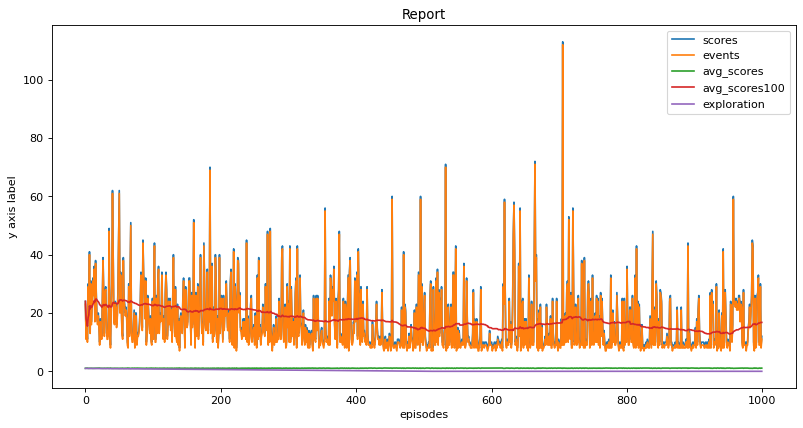

In [12]:
figure(figsize=(12, 6), dpi=80)
plt.plot(episodes, scores)
plt.plot(episodes, events)
plt.plot(episodes, avg_scores)
plt.plot(episodes, avg_scores100)
plt.plot(episodes, exploration)
plt.xlabel('episodes')
plt.ylabel('y axis label')
plt.title('Report')
plt.legend(['scores',  'events', 'avg_scores', 'avg_scores100','exploration'])
plt.show()

View Best Results

In [13]:
createMovie(bestNet,'bestNet')